In [3]:
"""
Over the air domain adaptation.

4 Modulations: bpsk, qpsk, 16qam and 16apsk.
Source SNR as 24, target from 10 to 22.
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Base
class CLDNN(nn.Module):
    def __init__(self, output_dim=4):
        super(CLDNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=8, stride=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        
        # After conv1 and pooling: input length 4096 becomes 4089 then 2044 after pooling.
        # So the flattened output from the LSTM will be 2044 * 64.
        self.fc1 = nn.Linear(2044 * 64, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        # x has shape: (batch, 2, 4096)
        x = self.conv1(x)      # -> (batch, 64, 4089)
        x = self.pool(x)       # -> (batch, 64, 2044)
        
        # Permute to have sequence first: (batch, 2044, 64)
        x = x.permute(0, 2, 1)
        
        x, _ = self.lstm1(x)   # -> (batch, 2044, 64)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)   # -> (batch, 2044, 64)
        x = self.dropout2(x)
        
        # Flatten: (batch, 2044*64)
        x = x.contiguous().view(x.size(0), -1)
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
#%% DANN
from torch.autograd import Function
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

def grad_reverse(x, alpha=1.0):
    return ReverseLayerF.apply(x, alpha)
class CLDNN_FA(nn.Module):
    def __init__(self):
        super(CLDNN_FA, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=8, stride=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        return x

class CLDNN_LP(nn.Module):
    def __init__(self, output_dim=7):
        super(CLDNN_LP, self).__init__()
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2044 * 64, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = x.contiguous().view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CLDNN_DC(nn.Module):
    def __init__(self):
        super(CLDNN_DC, self).__init__()
        self.fc1 = nn.Linear(2044 * 64, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x, alpha):
        x = ReverseLayerF.apply(x, alpha)
        x = x.contiguous().view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# star
class STAR_G(nn.Module):
    def __init__(self):
        super(STAR_G, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=8, stride=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x.contiguous().view(x.size(0), -1)
        return x

class STAR_C(nn.Module):
    def __init__(self, output_dim, num_classifiers_train=2, num_classifiers_test=20, init='kaiming_u', use_init=False):
        super(STAR_C, self).__init__()
        self.num_classifiers_train = num_classifiers_train
        self.num_classifiers_test = num_classifiers_test
        self.init = init

        function_init = {
            'kaiming_u': nn.init.kaiming_uniform_,
            'kaiming_n': nn.init.kaiming_normal_,
            'xavier': nn.init.xavier_normal_
        }

        self.fc1 = nn.Linear(2044 * 64, 128)
        self.bn1_fc = nn.BatchNorm1d(128)

        self.mu2 = nn.Parameter(torch.randn(output_dim, 128))
        self.sigma2 = nn.Parameter(torch.zeros(output_dim, 128))

        if use_init:
            all_parameters = [self.mu2, self.sigma2]
            for item in all_parameters:
                function_init[self.init](item)

        self.b2 = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x, only_mu=True):
        x = self.fc1(x)
        x = F.relu(self.bn1_fc(x))

        sigma2_pos = torch.sigmoid(self.sigma2)
        fc2_distribution = torch.distributions.Normal(self.mu2, sigma2_pos)

        if self.training:
            classifiers = []
            for _ in range(self.num_classifiers_train):
                fc2_w = fc2_distribution.rsample()
                classifiers.append([fc2_w, self.b2])

            outputs = []
            for classifier in classifiers:
                out = F.linear(x, classifier[0], classifier[1])
                outputs.append(out)

            return outputs
        else:
            if only_mu:
                out = F.linear(x, self.mu2, self.b2)
                return [out]
            else:
                classifiers = []
                for _ in range(self.num_classifiers_test):
                    fc2_w = fc2_distribution.rsample()
                    classifiers.append([fc2_w, self.b2])

                outputs = []
                for classifier in classifiers:
                    out = F.linear(x, classifier[0], classifier[1])
                    outputs.append(out)
                return outputs


#%% mcd
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradReverse.apply(x, lambda_)

class MCD_G(nn.Module):
    def __init__(self):
        super(MCD_G, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=8, stride=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x.contiguous().view(x.size(0), -1)
        return x
    
class MCD_C(nn.Module):
    def __init__(self, output_dim):
        super(MCD_C, self).__init__()
        self.fc1 = nn.Linear(2044 * 64, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x, reverse=False, lambda_=1.0):
        if reverse:
            x = grad_reverse(x, lambda_)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Load testbed data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# Split source, target
# try selecting some of the mods, not all
X = np.load(file_path + "/ota_X.npy")
Y = np.load(file_path + "/ota_Y.npy")

sou_snr = 30
tar_snr = 10

t_base_acc = []
t_dann_acc = []
t_star_acc = []
t_mcd_acc = []
t_coral_acc = []
t_jan_acc = []

s_base_acc = []
s_dann_acc = []
s_star_acc = []
s_mcd_acc = []
s_coral_acc = []
s_jan_acc = []

n_runs = 5
lr = 0.001

for i in range(6):    
    source_mask = (Y[:, 1] == sou_snr)
    target_mask = (Y[:, 1] == tar_snr)
    
    X_s = X[source_mask]
    Y_s = Y[source_mask]
    Y_s = Y_s[:,0]
    
    X_t = X[target_mask]
    Y_t = Y[target_mask]
    Y_t = Y_t[:,0]

    
    # Dataloaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, permute=False)

    s_base, t_base = base.Base(model_cls=CLDNN, device=device, S_train_loader=S_train_loader, 
                    S_val_loader=S_val_loader, T_val_loader=T_val_loader, class_subset=class_subset, 
                    n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_base_acc.append(s_base)
    t_base_acc.append(t_base)
    
    s_dan, t_dan = dann.DAN(dann.DANN, FA=CLDNN_FA, LP=CLDNN_LP, DC=CLDNN_DC,
                      device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,
                      T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                      class_subset=class_subset, n_classes=len(class_subset), lr=lr,
                      n_epochs=50, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_dann_acc.append(s_dan)
    t_dann_acc.append(t_dan)
    
    s_star, t_star = star.Star(G=STAR_G, C=STAR_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_star_acc.append(s_star)
    t_star_acc.append(t_star)
    
    s_mcd, t_mcd = mcd.Mcd(G=MCD_G, C=MCD_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_mcd_acc.append(s_mcd)
    t_mcd_acc.append(t_mcd)

    """
    s_coral, t_coral = coral.Coral(G=coral.CLDNN_G, C=coral.CLDNN_C, device=device, S_train_loader=S_train_loader,
                           S_val_loader=S_val_loader, T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                           class_subset=class_subset, n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs,
                           patience=5, lambda_coral=0.5).run()
    torch.cuda.empty_cache()
    s_coral_acc.append(s_coral)
    t_coral_acc.append(t_coral)

    s_jan, t_jan = jan.Jan(num_classes=len(class_subset), device=device, S_train_loader=S_train_loader,
                     T_train_loader=T_train_loader, S_val_loader=S_val_loader, T_val_loader=T_val_loader,
                     n_epochs=50, lr=lr, lambda_jmmd=0.1, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_jan_acc.append(s_jan)
    t_jan_acc.append(t_jan)
    """
    
    tar_snr += 4


Run 1/5
Epoch 1/50, Train Loss: 1.0364, Train Acc: 0.5303, Val Loss: 0.7761, Val Acc: 0.6211
Epoch 2/50, Train Loss: 0.7108, Train Acc: 0.6491, Val Loss: 0.5078, Val Acc: 0.7416
Epoch 3/50, Train Loss: 0.2640, Train Acc: 0.8998, Val Loss: 0.0426, Val Acc: 0.9886
Epoch 4/50, Train Loss: 0.1324, Train Acc: 0.9640, Val Loss: 0.1633, Val Acc: 0.9532
Epoch 5/50, Train Loss: 0.1069, Train Acc: 0.9724, Val Loss: 0.1089, Val Acc: 0.9682
Epoch 6/50, Train Loss: 0.0332, Train Acc: 0.9898, Val Loss: 0.0818, Val Acc: 0.9814
Epoch 7/50, Train Loss: 0.0449, Train Acc: 0.9897, Val Loss: 0.0225, Val Acc: 0.9928
Epoch 8/50, Train Loss: 0.0865, Train Acc: 0.9807, Val Loss: 0.0161, Val Acc: 0.9952
Epoch 9/50, Train Loss: 0.0169, Train Acc: 0.9964, Val Loss: 0.1032, Val Acc: 0.9790
Epoch 10/50, Train Loss: 0.0226, Train Acc: 0.9939, Val Loss: 0.0502, Val Acc: 0.9868
Epoch 11/50, Train Loss: 0.0048, Train Acc: 0.9987, Val Loss: 0.0075, Val Acc: 0.9976
Epoch 12/50, Train Loss: 0.0033, Train Acc: 0.9991, Va

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Run 2/5
Epoch 1/50, Train Loss: 1.1355, Train Acc: 0.5268, Val Loss: 0.7137, Val Acc: 0.6193
Epoch 2/50, Train Loss: 0.7280, Train Acc: 0.6329, Val Loss: 0.6112, Val Acc: 0.6865
Epoch 3/50, Train Loss: 0.2496, Train Acc: 0.9025, Val Loss: 0.0683, Val Acc: 0.9832
Epoch 4/50, Train Loss: 0.0843, Train Acc: 0.9735, Val Loss: 0.1839, Val Acc: 0.9538
Epoch 5/50, Train Loss: 0.0863, Train Acc: 0.9772, Val Loss: 0.0248, Val Acc: 0.9910
Epoch 6/50, Train Loss: 0.0275, Train Acc: 0.9925, Val Loss: 0.0217, Val Acc: 0.9940
Epoch 7/50, Train Loss: 0.0752, Train Acc: 0.9778, Val Loss: 0.0312, Val Acc: 0.9898
Epoch 8/50, Train Loss: 0.0274, Train Acc: 0.9924, Val Loss: 0.0262, Val Acc: 0.9934
Epoch 9/50, Train Loss: 0.0257, Train Acc: 0.9942, Val Loss: 0.0206, Val Acc: 0.9940
Epoch 10/50, Train Loss: 0.0353, Train Acc: 0.9903, Val Loss: 0.0226, Val Acc: 0.9928
Epoch 11/50, Train Loss: 0.0036, Train Acc: 0.9988, Val Loss: 0.0121, Val Acc: 0.9946
Epoch 12/50, Train Loss: 0.0035, Train Acc: 0.9991, Va

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Run 3/5
Epoch 1/50, Train Loss: 1.0545, Train Acc: 0.5406, Val Loss: 0.9535, Val Acc: 0.5294
Epoch 2/50, Train Loss: 0.7433, Train Acc: 0.6230, Val Loss: 0.7214, Val Acc: 0.6241
Epoch 3/50, Train Loss: 0.6095, Train Acc: 0.7185, Val Loss: 1.2357, Val Acc: 0.6739
Epoch 4/50, Train Loss: 0.2063, Train Acc: 0.9352, Val Loss: 0.1517, Val Acc: 0.9371
Epoch 5/50, Train Loss: 0.0820, Train Acc: 0.9766, Val Loss: 0.1564, Val Acc: 0.9556
Epoch 6/50, Train Loss: 0.0552, Train Acc: 0.9843, Val Loss: 0.0145, Val Acc: 0.9934
Epoch 7/50, Train Loss: 0.0393, Train Acc: 0.9880, Val Loss: 0.0384, Val Acc: 0.9922
Epoch 8/50, Train Loss: 0.0608, Train Acc: 0.9868, Val Loss: 0.0517, Val Acc: 0.9868
Epoch 9/50, Train Loss: 0.0981, Train Acc: 0.9766, Val Loss: 0.0324, Val Acc: 0.9922
Epoch 10/50, Train Loss: 0.0161, Train Acc: 0.9961, Val Loss: 0.0776, Val Acc: 0.9832
Epoch 11/50, Train Loss: 0.0081, Train Acc: 0.9978, Val Loss: 0.0070, Val Acc: 0.9976
Epoch 12/50, Train Loss: 0.0031, Train Acc: 0.9993, Va

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Run 4/5
Epoch 1/50, Train Loss: 1.0041, Train Acc: 0.5474, Val Loss: 0.7251, Val Acc: 0.6271
Epoch 2/50, Train Loss: 0.6397, Train Acc: 0.6813, Val Loss: 0.3311, Val Acc: 0.8777
Epoch 3/50, Train Loss: 0.2472, Train Acc: 0.9267, Val Loss: 0.0271, Val Acc: 0.9928
Epoch 4/50, Train Loss: 0.0777, Train Acc: 0.9772, Val Loss: 0.4777, Val Acc: 0.9209
Epoch 5/50, Train Loss: 0.0727, Train Acc: 0.9793, Val Loss: 0.3439, Val Acc: 0.9335
Epoch 6/50, Train Loss: 0.0311, Train Acc: 0.9906, Val Loss: 0.0133, Val Acc: 0.9982
Epoch 7/50, Train Loss: 0.0444, Train Acc: 0.9901, Val Loss: 0.0350, Val Acc: 0.9910
Epoch 8/50, Train Loss: 0.0459, Train Acc: 0.9861, Val Loss: 0.0507, Val Acc: 0.9808
Epoch 9/50, Train Loss: 0.0191, Train Acc: 0.9954, Val Loss: 0.0038, Val Acc: 0.9982
Epoch 10/50, Train Loss: 0.0456, Train Acc: 0.9900, Val Loss: 0.0254, Val Acc: 0.9946
Epoch 11/50, Train Loss: 0.0045, Train Acc: 0.9988, Val Loss: 0.0216, Val Acc: 0.9952
Epoch 12/50, Train Loss: 0.0042, Train Acc: 0.9991, Va

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Run 5/5
Epoch 1/50, Train Loss: 0.9352, Train Acc: 0.5418, Val Loss: 0.8635, Val Acc: 0.5600
Epoch 2/50, Train Loss: 0.7476, Train Acc: 0.6320, Val Loss: 0.5918, Val Acc: 0.6936
Epoch 3/50, Train Loss: 0.2934, Train Acc: 0.8817, Val Loss: 0.1267, Val Acc: 0.9598
Epoch 4/50, Train Loss: 0.1048, Train Acc: 0.9681, Val Loss: 0.0271, Val Acc: 0.9928
Epoch 5/50, Train Loss: 0.0709, Train Acc: 0.9789, Val Loss: 0.3264, Val Acc: 0.9359
Epoch 6/50, Train Loss: 0.0444, Train Acc: 0.9873, Val Loss: 0.0373, Val Acc: 0.9868
Epoch 7/50, Train Loss: 0.0465, Train Acc: 0.9862, Val Loss: 0.0270, Val Acc: 0.9904
Epoch 8/50, Train Loss: 0.0662, Train Acc: 0.9823, Val Loss: 0.0245, Val Acc: 0.9952
Epoch 9/50, Train Loss: 0.0278, Train Acc: 0.9933, Val Loss: 0.0909, Val Acc: 0.9832
Epoch 10/50, Train Loss: 0.0409, Train Acc: 0.9901, Val Loss: 0.0381, Val Acc: 0.9934
Epoch 11/50, Train Loss: 0.0043, Train Acc: 0.9990, Val Loss: 0.0210, Val Acc: 0.9964
Epoch 12/50, Train Loss: 0.0036, Train Acc: 0.9991, Va

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Source performance: 99.72 99.73 99.72 99.73
Target performance: 51.80 42.74 51.93 44.97

bpsk: 82.21
qpsk: 0.00
16qam: 27.80
8apsk: 97.71
Epoch 1/50, Loss: 3.5108, Domain Loss: 1.6322, Class Loss: 1.8786
Epoch 2/50, Loss: 2.0047, Domain Loss: 1.1342, Class Loss: 0.8705
Epoch 3/50, Loss: 1.8810, Domain Loss: 1.1109, Class Loss: 0.7701
Epoch 4/50, Loss: 2.3582, Domain Loss: 1.4098, Class Loss: 0.9483
Epoch 5/50, Loss: 2.2578, Domain Loss: 1.4037, Class Loss: 0.8541
Epoch 6/50, Loss: 1.9842, Domain Loss: 1.1851, Class Loss: 0.7990
Epoch 7/50, Loss: 1.8825, Domain Loss: 1.1412, Class Loss: 0.7412
Epoch 8/50, Loss: 1.7927, Domain Loss: 1.0518, Class Loss: 0.7409
Epoch 9/50, Loss: 1.8719, Domain Loss: 1.1092, Class Loss: 0.7628
Epoch 10/50, Loss: 1.8629, Domain Loss: 1.1063, Class Loss: 0.7566
Epoch 11/50, Loss: 1.8915, Domain Loss: 1.1343, Class Loss: 0.7572
Epoch 12/50, Loss: 2.1463, Domain Loss: 1.2285, Class Loss: 0.9178
Epoch 13/50, Loss: 12.3131, Domain Loss: 9.6029, Class Loss: 2.710

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


24.76


Epoch 1/50, Loss: 4.0852, Domain Loss: 2.0894, Class Loss: 1.9958
Epoch 2/50, Loss: 2.2424, Domain Loss: 1.1171, Class Loss: 1.1254
Epoch 3/50, Loss: 1.7672, Domain Loss: 0.9501, Class Loss: 0.8171
Epoch 4/50, Loss: 1.7066, Domain Loss: 0.9135, Class Loss: 0.7930
Epoch 5/50, Loss: 1.8304, Domain Loss: 0.9691, Class Loss: 0.8613
Epoch 6/50, Loss: 1.7820, Domain Loss: 0.9804, Class Loss: 0.8016
Epoch 7/50, Loss: 4.6445, Domain Loss: 3.4838, Class Loss: 1.1607
Epoch 8/50, Loss: 14.7917, Domain Loss: 13.6771, Class Loss: 1.1146
Epoch 9/50, Loss: 22.2298, Domain Loss: 20.3646, Class Loss: 1.8652
Epoch 10/50, Loss: 17.9260, Domain Loss: 16.6425, Class Loss: 1.2835
Epoch 11/50, Loss: 22.7420, Domain Loss: 21.2620, Class Loss: 1.4800
Epoch 12/50, Loss: 17.7461, Domain Loss: 16.4895, Class Loss: 1.2566
Epoch 13/50, Loss: 9.6830, Domain Loss: 8.8825, Class Loss: 0.8004
Epoch 14/50, Loss: 16.6832, Domain Loss: 15.2972, Class Loss: 1.3860
Epoch 15/50, Loss: 14.6568, Domain Loss: 13.7047, C

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45.98


Epoch 1/50, Loss: 3.6535, Domain Loss: 1.9970, Class Loss: 1.6565
Epoch 2/50, Loss: 2.0261, Domain Loss: 1.2106, Class Loss: 0.8155
Epoch 3/50, Loss: 1.8327, Domain Loss: 1.0629, Class Loss: 0.7699
Epoch 4/50, Loss: 2.2705, Domain Loss: 1.5150, Class Loss: 0.7555
Epoch 5/50, Loss: 3.2842, Domain Loss: 2.3834, Class Loss: 0.9008
Epoch 6/50, Loss: 2.4907, Domain Loss: 1.6885, Class Loss: 0.8022
Epoch 7/50, Loss: 4.4755, Domain Loss: 3.5905, Class Loss: 0.8851
Epoch 8/50, Loss: 5.1621, Domain Loss: 3.9079, Class Loss: 1.2542
Epoch 9/50, Loss: 3.2932, Domain Loss: 2.4547, Class Loss: 0.8384
Epoch 10/50, Loss: 3.4767, Domain Loss: 2.6549, Class Loss: 0.8217
Epoch 11/50, Loss: 5.8339, Domain Loss: 4.9397, Class Loss: 0.8942
Epoch 12/50, Loss: 12.7820, Domain Loss: 11.8474, Class Loss: 0.9345
Epoch 13/50, Loss: 15.1817, Domain Loss: 14.2087, Class Loss: 0.9730
Epoch 14/50, Loss: 6.8640, Domain Loss: 6.0146, Class Loss: 0.8494
Epoch 15/50, Loss: 4.7391, Domain Loss: 3.9319, Class Loss:

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


24.40


Epoch 1/50, Loss: 3.7812, Domain Loss: 1.9874, Class Loss: 1.7938
Epoch 2/50, Loss: 3.0097, Domain Loss: 2.0786, Class Loss: 0.9311
Epoch 3/50, Loss: 3.7184, Domain Loss: 2.7218, Class Loss: 0.9966
Epoch 4/50, Loss: 2.2141, Domain Loss: 1.3645, Class Loss: 0.8496
Epoch 5/50, Loss: 1.9357, Domain Loss: 1.1522, Class Loss: 0.7835
Epoch 6/50, Loss: 1.8070, Domain Loss: 1.0698, Class Loss: 0.7373
Epoch 7/50, Loss: 1.7918, Domain Loss: 1.0694, Class Loss: 0.7224
Epoch 8/50, Loss: 1.7776, Domain Loss: 1.0605, Class Loss: 0.7172
Epoch 9/50, Loss: 1.7489, Domain Loss: 1.0220, Class Loss: 0.7270
Epoch 10/50, Loss: 1.8368, Domain Loss: 1.0452, Class Loss: 0.7916
Epoch 11/50, Loss: 1.7343, Domain Loss: 0.9935, Class Loss: 0.7408
Epoch 12/50, Loss: 2.0299, Domain Loss: 1.1315, Class Loss: 0.8984
Epoch 13/50, Loss: 1.8963, Domain Loss: 1.1078, Class Loss: 0.7885
Epoch 14/50, Loss: 1.7289, Domain Loss: 0.9961, Class Loss: 0.7328
Epoch 15/50, Loss: 1.9703, Domain Loss: 1.1301, Class Loss: 0.8

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


60.79


Source performance:
57.30 48.34 57.76 50.17 
Target performance:
39.81 31.06 40.24 28.30 

Per-class target performance: 79.90 47.75 21.78 11.52 
Run 1/5
Epoch [1/50], Class Loss: 3.2515, Discrepancy Loss: 0.1043
Epoch [2/50], Class Loss: 1.5065, Discrepancy Loss: 0.1330
Epoch [3/50], Class Loss: 1.2834, Discrepancy Loss: 0.1344
Epoch [4/50], Class Loss: 0.8386, Discrepancy Loss: 0.1384
Epoch [5/50], Class Loss: 0.2575, Discrepancy Loss: 0.1074
Epoch [6/50], Class Loss: 0.1522, Discrepancy Loss: 0.0963
Epoch [7/50], Class Loss: 0.1122, Discrepancy Loss: 0.0990
Epoch [8/50], Class Loss: 0.1231, Discrepancy Loss: 0.0971
Epoch [9/50], Class Loss: 0.0920, Discrepancy Loss: 0.0966
Epoch [10/50], Class Loss: 0.1317, Discrepancy Loss: 0.1034
Epoch [11/50], Class Loss: 0.1008, Discrepancy Loss: 0.0963
Epoch [12/50], Class Loss: 0.0431, Discrepancy Loss: 0.0805
Epoch [13/50], Class Loss: 0.0370, Discrepancy Loss: 0.0763
Epoch [14/50], Class Loss: 0.0437, Discrepancy Loss: 0.0748
Epoch [

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Run 4/5
Epoch 1/50, Train Loss: 0.9507, Train Acc: 0.5472, Val Loss: 0.7433, Val Acc: 0.6301
Epoch 2/50, Train Loss: 0.6868, Train Acc: 0.6540, Val Loss: 0.4613, Val Acc: 0.7092
Epoch 3/50, Train Loss: 0.1486, Train Acc: 0.9459, Val Loss: 0.0464, Val Acc: 0.9856
Epoch 4/50, Train Loss: 0.0811, Train Acc: 0.9756, Val Loss: 0.1956, Val Acc: 0.9400
Epoch 5/50, Train Loss: 0.0603, Train Acc: 0.9817, Val Loss: 0.0797, Val Acc: 0.9826
Epoch 6/50, Train Loss: 0.0707, Train Acc: 0.9820, Val Loss: 0.0380, Val Acc: 0.9928
Epoch 7/50, Train Loss: 0.0468, Train Acc: 0.9888, Val Loss: 0.0421, Val Acc: 0.9910
Epoch 8/50, Train Loss: 0.0434, Train Acc: 0.9883, Val Loss: 0.0701, Val Acc: 0.9868
Epoch 9/50, Train Loss: 0.0204, Train Acc: 0.9945, Val Loss: 0.0214, Val Acc: 0.9970
Epoch 10/50, Train Loss: 0.0098, Train Acc: 0.9981, Val Loss: 0.0230, Val Acc: 0.9952
Epoch 11/50, Train Loss: 0.0052, Train Acc: 0.9990, Val Loss: 0.0220, Val Acc: 0.9964
Epoch 12/50, Train Loss: 0.0032, Train Acc: 0.9996, Va

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


24.88


Epoch 1/50, Loss: 3.8293, Domain Loss: 1.9772, Class Loss: 1.8521
Epoch 2/50, Loss: 2.3920, Domain Loss: 1.3746, Class Loss: 1.0174
Epoch 3/50, Loss: 2.5751, Domain Loss: 1.6600, Class Loss: 0.9151
Epoch 4/50, Loss: 2.0177, Domain Loss: 1.2543, Class Loss: 0.7634
Epoch 5/50, Loss: 1.8773, Domain Loss: 1.1449, Class Loss: 0.7324
Epoch 6/50, Loss: 2.0054, Domain Loss: 1.2453, Class Loss: 0.7601
Epoch 7/50, Loss: 1.8739, Domain Loss: 1.1557, Class Loss: 0.7182
Epoch 8/50, Loss: 1.8969, Domain Loss: 1.1769, Class Loss: 0.7201
Epoch 9/50, Loss: 2.0447, Domain Loss: 1.2727, Class Loss: 0.7720
Epoch 10/50, Loss: 2.3837, Domain Loss: 1.5748, Class Loss: 0.8089
Epoch 11/50, Loss: 30.8538, Domain Loss: 27.8062, Class Loss: 3.0476
Epoch 12/50, Loss: 15.8376, Domain Loss: 14.3228, Class Loss: 1.5148
Epoch 13/50, Loss: 4.4918, Domain Loss: 3.1013, Class Loss: 1.3905
Epoch 14/50, Loss: 2.8893, Domain Loss: 1.5004, Class Loss: 1.3889
Epoch 15/50, Loss: 2.8287, Domain Loss: 1.4407, Class Loss:

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25.72


Epoch 1/50, Loss: 3.4510, Domain Loss: 1.7168, Class Loss: 1.7342
Epoch 2/50, Loss: 2.3519, Domain Loss: 1.4279, Class Loss: 0.9240
Epoch 3/50, Loss: 1.9564, Domain Loss: 1.1948, Class Loss: 0.7616
Epoch 4/50, Loss: 2.0627, Domain Loss: 1.2432, Class Loss: 0.8195
Epoch 5/50, Loss: 1.9168, Domain Loss: 1.1423, Class Loss: 0.7746
Epoch 6/50, Loss: 1.8808, Domain Loss: 1.1054, Class Loss: 0.7754
Epoch 7/50, Loss: 1.8842, Domain Loss: 1.1168, Class Loss: 0.7675
Epoch 8/50, Loss: 1.8012, Domain Loss: 1.0717, Class Loss: 0.7295
Epoch 9/50, Loss: 2.1666, Domain Loss: 1.2761, Class Loss: 0.8905
Epoch 10/50, Loss: 2.2476, Domain Loss: 1.2473, Class Loss: 1.0003
Epoch 11/50, Loss: 1.9906, Domain Loss: 1.1541, Class Loss: 0.8365
Epoch 12/50, Loss: 2.2372, Domain Loss: 1.3335, Class Loss: 0.9038
Epoch 13/50, Loss: 2.2345, Domain Loss: 1.3063, Class Loss: 0.9281
Epoch 14/50, Loss: 2.2920, Domain Loss: 1.3703, Class Loss: 0.9217
Epoch 15/50, Loss: 2.1080, Domain Loss: 1.2724, Class Loss: 0.8

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


50.30


Epoch 1/50, Loss: 4.1274, Domain Loss: 1.8369, Class Loss: 2.2905
Epoch 2/50, Loss: 2.5109, Domain Loss: 1.3915, Class Loss: 1.1195
Epoch 3/50, Loss: 2.1676, Domain Loss: 1.3631, Class Loss: 0.8045
Epoch 4/50, Loss: 2.1423, Domain Loss: 1.3962, Class Loss: 0.7461
Epoch 5/50, Loss: 2.0907, Domain Loss: 1.3417, Class Loss: 0.7490
Epoch 6/50, Loss: 2.0512, Domain Loss: 1.3235, Class Loss: 0.7277
Epoch 7/50, Loss: 2.0581, Domain Loss: 1.2830, Class Loss: 0.7751
Epoch 8/50, Loss: 1.9688, Domain Loss: 1.2051, Class Loss: 0.7636
Epoch 9/50, Loss: 1.9654, Domain Loss: 1.2053, Class Loss: 0.7601
Epoch 10/50, Loss: 2.1792, Domain Loss: 1.3712, Class Loss: 0.8080
Epoch 11/50, Loss: 3.6680, Domain Loss: 2.3855, Class Loss: 1.2825
Epoch 12/50, Loss: 10.7009, Domain Loss: 8.5842, Class Loss: 2.1167
Epoch 13/50, Loss: 3.4585, Domain Loss: 2.0090, Class Loss: 1.4495
Epoch 14/50, Loss: 2.8295, Domain Loss: 1.4212, Class Loss: 1.4083
Epoch 15/50, Loss: 2.8057, Domain Loss: 1.4049, Class Loss: 1.

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


26.80


Source performance:
81.99 80.25 82.12 79.70 
Target performance:
80.19 78.58 80.03 77.27 

Per-class target performance: 98.88 74.55 69.17 77.54 
Run 1/5
Epoch [1/50], Class Loss: 3.6033, Discrepancy Loss: 0.1172
Epoch [2/50], Class Loss: 1.4806, Discrepancy Loss: 0.1444
Epoch [3/50], Class Loss: 1.2414, Discrepancy Loss: 0.1405
Epoch [4/50], Class Loss: 1.1977, Discrepancy Loss: 0.1404
Epoch [5/50], Class Loss: 1.0007, Discrepancy Loss: 0.1363
Epoch [6/50], Class Loss: 0.3304, Discrepancy Loss: 0.0545
Epoch [7/50], Class Loss: 0.1201, Discrepancy Loss: 0.0310
Epoch [8/50], Class Loss: 0.0834, Discrepancy Loss: 0.0241
Epoch [9/50], Class Loss: 0.1009, Discrepancy Loss: 0.0235
Epoch [10/50], Class Loss: 0.1056, Discrepancy Loss: 0.0222
Epoch [11/50], Class Loss: 0.0435, Discrepancy Loss: 0.0148
Epoch [12/50], Class Loss: 0.0426, Discrepancy Loss: 0.0143
Epoch [13/50], Class Loss: 0.0424, Discrepancy Loss: 0.0132
Epoch [14/50], Class Loss: 0.0406, Discrepancy Loss: 0.0176
Epoch [

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


23.86


Source performance:
82.54 79.04 82.46 79.45 
Target performance:
82.41 78.98 82.63 79.55 

Per-class target performance: 98.39 78.38 76.79 76.96 
Run 1/5
Epoch [1/50], Class Loss: 2.6151, Discrepancy Loss: 0.1399
Epoch [2/50], Class Loss: 1.2629, Discrepancy Loss: 0.1518
Epoch [3/50], Class Loss: 1.0643, Discrepancy Loss: 0.1400
Epoch [4/50], Class Loss: 0.3291, Discrepancy Loss: 0.0526
Epoch [5/50], Class Loss: 0.2920, Discrepancy Loss: 0.0428
Epoch [6/50], Class Loss: 0.3269, Discrepancy Loss: 0.0560
Epoch [7/50], Class Loss: 0.1333, Discrepancy Loss: 0.0291
Epoch [8/50], Class Loss: 0.0955, Discrepancy Loss: 0.0215
Epoch [9/50], Class Loss: 0.0961, Discrepancy Loss: 0.0158
Epoch [10/50], Class Loss: 0.1133, Discrepancy Loss: 0.0207
Epoch [11/50], Class Loss: 0.0476, Discrepancy Loss: 0.0111
Epoch [12/50], Class Loss: 0.0374, Discrepancy Loss: 0.0117
Epoch [13/50], Class Loss: 0.0582, Discrepancy Loss: 0.0131
Epoch [14/50], Class Loss: 0.0424, Discrepancy Loss: 0.0142
Epoch [

6
6


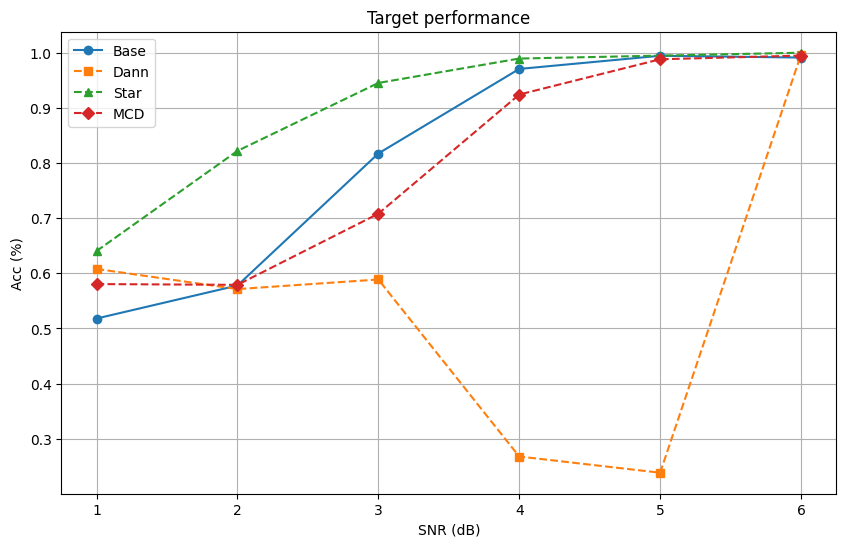

In [9]:
"""
x = np.arange(1, 5)
print(len(s_base_acc))

plt.figure(figsize=(10, 6))
plt.plot(x, s_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, s_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, s_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, s_mcd_acc, marker='D', linestyle='--', label='MCD')
#plt.plot(x, s_coral_acc, marker='v', linestyle='--', label='CORAL')
#plt.plot(x, s_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Source performance')
plt.legend()
plt.grid(True)
plt.show()
"""

x = np.arange(1, 7)
print(len(x))
print(len(t_base_acc))

plt.figure(figsize=(10, 6))
plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
#plt.plot(x, t_coral_acc, marker='v', linestyle='--', label='CORAL')
#plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Target performance')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Load testbed data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes
class_subset = ["bpsk", "qpsk", "16qam", "8apsk"]

# Split source, target
# try selecting some of the mods, not all
X = np.load(file_path + "/sim_X.npy")
Y = np.load(file_path + "/sim_Y.npy")

sou_snr = 22
tar_snr = 10

t_base_acc = []
t_dann_acc = []
t_star_acc = []
t_mcd_acc = []
t_coral_acc = []
t_jan_acc = []

s_base_acc = []
s_dann_acc = []
s_star_acc = []
s_mcd_acc = []
s_coral_acc = []
s_jan_acc = []

n_runs = 10
lr = 0.001
n_snr = 4
offset_snr = 4

import torch
import torch.nn as nn

for i in range(n_snr-1):    
    source_mask = (Y[:, 1] == sou_snr)
    target_mask = (Y[:, 1] == tar_snr)
    
    X_s = X[source_mask]
    Y_s = Y[source_mask]
    Y_s = Y_s[:,0]
    
    X_t = X[target_mask]
    Y_t = Y[target_mask]
    Y_t = Y_t[:,0]

    
    # Dataloaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, permute=False)

    s_mcd, t_mcd = mcd.Mcd(G=MCD_G, C=MCD_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_mcd_acc.append(s_mcd)
    t_mcd_acc.append(t_mcd)

    s_base, t_base = base.Base(model_cls=CLDNN, device=device, S_train_loader=S_train_loader, 
                    S_val_loader=S_val_loader, T_val_loader=T_val_loader, class_subset=class_subset, 
                    n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_base_acc.append(s_base)
    t_base_acc.append(t_base)
    
    s_dan, t_dan = dann.DAN(dann.DANN, FA=CLDNN_FA, LP=CLDNN_LP, DC=CLDNN_DC,
                      device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,
                      T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                      class_subset=class_subset, n_classes=len(class_subset), lr=lr,
                      n_epochs=50, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_dann_acc.append(s_dan)
    t_dann_acc.append(t_dan)
    
    s_star, t_star = star.Star(G=STAR_G, C=STAR_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_star_acc.append(s_star)
    t_star_acc.append(t_star)

    tar_snr += offset_snr

x = np.arange(1, 5)

plt.figure(figsize=(10, 6))
plt.plot(x, s_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, s_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, s_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, s_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Target performance')
plt.legend()
plt.grid(True)
plt.show()

"""
for i in range(n_snr):    
    source_mask = (Y[:, 1] == sou_snr)
    target_mask = (Y[:, 1] == tar_snr)
    
    X_s = X[source_mask]
    Y_s = Y[source_mask]
    Y_s = Y_s[:,0]
    
    X_t = X[target_mask]
    Y_t = Y[target_mask]
    Y_t = Y_t[:,0]

    
    # Dataloaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, permute=False)

    s_base, t_base = base.Base(model_cls=CLDNN, device=device, S_train_loader=S_train_loader, 
                    S_val_loader=S_val_loader, T_val_loader=T_val_loader, class_subset=class_subset, 
                    n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_base_acc.append(s_base)
    t_base_acc.append(t_base)
    
    s_dan, t_dan = dann.DAN(dann.DANN, FA=dann.CLDNN_FA, LP=dann.CLDNN_LP, DC=dann.CLDNN_DC,
                      device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,
                      T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                      class_subset=class_subset, n_classes=len(class_subset), lr=lr,
                      n_epochs=25, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_dann_acc.append(s_dan)
    t_dann_acc.append(t_dan)
    
    s_star, t_star = star.Star(G=star.CLDNN_G, C=star.CLDNN_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_star_acc.append(s_star)
    t_star_acc.append(t_star)
    
    s_mcd, t_mcd = mcd.Mcd(G=mcd.CLDNN_G, C=mcd.CLDNN_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_mcd_acc.append(s_mcd)
    t_mcd_acc.append(t_mcd)
    
    s_coral, t_coral = coral.Coral(G=coral.CLDNN_G, C=coral.CLDNN_C, device=device, S_train_loader=S_train_loader,
                           S_val_loader=S_val_loader, T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                           class_subset=class_subset, n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs,
                           patience=5, lambda_coral=0.5).run()
    torch.cuda.empty_cache()
    s_coral_acc.append(s_coral)
    t_coral_acc.append(t_coral)

    s_jan, t_jan = jan.Jan(num_classes=len(class_subset), device=device, S_train_loader=S_train_loader,
                     T_train_loader=T_train_loader, S_val_loader=S_val_loader, T_val_loader=T_val_loader,
                     n_epochs=50, lr=lr, lambda_jmmd=0.1, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_jan_acc.append(s_jan)
    t_jan_acc.append(t_jan)
    
    tar_snr += offset_snr
"""

In [ ]:
x = np.arange(1, 4)

plt.figure(figsize=(10, 6))
plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Target performance')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x = np.arange(1, 8)

plt.figure(figsize=(10, 6))
plt.plot(x, s_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, s_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, s_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, s_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, s_coral_acc, marker='v', linestyle='--', label='CORAL')
plt.plot(x, s_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Source performance')
plt.legend()
plt.grid(True)
plt.show()


x = np.arange(1, 8)

plt.figure(figsize=(10, 6))
plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_coral_acc, marker='v', linestyle='--', label='CORAL')
plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.title('Target performance')
plt.legend()
plt.grid(True)
plt.show()